# COVID-19 & Stay-at-Home Orders in the US

#### Cameron Cofskey

## Introduction 

### Sources

This analysis focuses on the effectiveness of stay-at-home orders in the United States by state. The data comes from 2 sources: 

* *New York Times* - "See Which States and Cities Have Told Residents to Stay at Home" (https://www.nytimes.com/interactive/2020/us/coronavirus-stay-at-home-order.html)
    * Provides stay-at-home order dates and population for each state
* *Kaggle* - "COVID-19 in USA" (https://www.kaggle.com/sudalairajkumar/covid19-in-usa/version/32#us_states_covid19_daily.csv)
    * Provides data on the number of cases, positive tests and deaths for each day & state

### Abstract

There are a several key assumptions that will be important to the understanding of this analysis. 

1. **Limited Disease Spread** - This is the idea that there will be a fixed number of COVID-19 cases in the United States. It can be helpful to think of this in terms of a fixed time period (e.g. the next year, 5 years, or until the eventual eradication of the disease). No matter the time period, there will be a fixed number of cases of COVID-19 contracted, though we do not yet know what this number will be. 

2. **Limited Healthcare Capacity** - This is the idea that at any given point in time, there is a maximum capacity of our healthcare system. Above this point, the quality of care will diminish or disappear altogether, leading to a greater number of higher severity cases and even death.

3. **Flattening the Curve** - This idea has become a bit of a buzzword recently, but what does it really mean? In its simplest form, it is merely a combination of the first 2 statements above. There are (and will continue to be) cases of COVID-19 in the United States. The key to overcoming this disease and returning to some normalcy will require that the cases do not occur in too close of proximity to each other, due to the limited healthcare capacity. If we are able to spread out the cases over a longer time frame, it gives healthcare workers, scientists working on a vaccine, the government, and others more time to react to these unprecedented events. 

**Summary**: 

* **Goal** - Minimize the cumulative number of deaths
* **Method** - Spreading out the number of positive cases over as long of a time frame as possible
* **Metrics of Success** - The rate of increase in the number of positive cases & increase in the death rate. 

This analysis focuses on the metrics of success for each state.

## Import Packages

In [1]:
import requests # html reader
from bs4 import BeautifulSoup # html parsing
import pandas as pd # data frames
import datetime # date calculations
import matplotlib.pyplot as plt # plotting
import seaborn as sns # pairs plot
import fbprophet # forecasting
import math # basic math functions
import matplotlib.dates as mdates # date formatting
from sklearn.linear_model import LinearRegression # model building
from sklearn.model_selection import train_test_split # model test / train splitting

Importing plotly failed. Interactive plots will not work.


## Scrape NYT article

### Initialize Beautiful Soup Object

In [2]:
# Get URL
URL = 'https://www.nytimes.com/interactive/2020/us/coronavirus-stay-at-home-order.html'
page = requests.get(URL)

In [3]:
# Initialize Soup Object
soup = BeautifulSoup(page.content, 'html.parser')

### Parse HTML & Format Results

In [4]:
# Dig into list-wrap element of html, where state data exists
results = soup.find('div', class_= 'list-wrap')

In [5]:
# Each state is divided by this header
state_orders = results.find_all('div', class_='state-wrap statewide')

In [6]:
# Pull the specific elements where each data element is & extract the info

# Initialize lists to store data
State = []
population_elem = []
order_date_elem = []

for state_orders in state_orders:
    State.append(state_orders['data-state'])
    population_elem.append(state_orders.find('span', class_='l-population').text)
    order_date_elem.append(state_orders.find('span', class_='l-date').text)

In [7]:
# Format the population data into a list
Population = []

for population_elem in population_elem:
    text = population_elem.split()
    if text[2] == 'million':
        Population.append(int(float(text[1]) * 1000000))
    else:
        Population.append(int(text[1].replace(',', '')))

In [8]:
# Format the date information into a list
SAH_Month = []
SAH_Day = []

for order_date_elem in order_date_elem:
    text = order_date_elem.split()
    SAH_Month.append(text[2])
    SAH_Day.append(text[3])

# Reformat Month to number
for i in range(len(SAH_Month)):
    datetime_object = datetime.datetime.strptime(SAH_Month[i], "%B")
    month_number = datetime_object.month
    SAH_Month[i] = month_number

In [9]:
# Create the Year list to match the others
SAH_Year = []
for i in range(len(SAH_Month)):
    SAH_Year.append(2020)

In [10]:
# Create date column
date = pd.DataFrame({'year' : SAH_Year,
                     'month' : SAH_Month,
                     'day' : SAH_Day})
Date = pd.to_datetime(date[['month', 'day', 'year']])

### Store results in dataframe 

In [11]:
# Create data frame
dict = {'state' : State, 
        'SAH_Order_Date' : Date,
        'Population' : Population
       }
SAH_data = pd.DataFrame(dict)

# Sort by state name & then SAH Order date
SAH_data = SAH_data.sort_values(by = ['state', 'SAH_Order_Date'], ascending= (True, True)) 
SAH_data.head()

,state,SAH_Order_Date,Population
1,AK,2020-03-28,737000
0,AL,2020-04-04,4900000
2,AZ,2020-03-31,7200000
3,CA,2020-03-19,39600000
4,CO,2020-03-26,5700000


## Initialize Kaggle Data

### Import Data

In [12]:
# Import data & look at features
states = pd.read_csv('C:/Users/camco/Downloads/us_states_covid19_daily.csv')
states.shape

(2228, 25)

In [13]:
states.head()

,date,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,hospitalized,total,totalTestResults,posNeg,fips,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
0,20200414,AK,285.0,8063.0,NaN,NaN,32.0,NaN,NaN,NaN,...,32.0,8348.0,8348.0,8348.0,2,1.0,0.0,510.0,8.0,518.0
1,20200414,AL,3876.0,29241.0,NaN,NaN,493.0,NaN,210.0,NaN,...,493.0,33117.0,33117.0,33117.0,1,11.0,36.0,3793.0,142.0,3935.0
2,20200414,AR,1480.0,19651.0,NaN,81.0,130.0,NaN,43.0,29.0,...,130.0,21131.0,21131.0,21131.0,5,0.0,0.0,257.0,70.0,327.0
3,20200414,AS,0.0,3.0,17.0,NaN,NaN,NaN,NaN,NaN,...,NaN,20.0,3.0,3.0,60,0.0,0.0,0.0,0.0,0.0
4,20200414,AZ,3806.0,40290.0,NaN,580.0,NaN,286.0,NaN,216.0,...,NaN,44096.0,44096.0,44096.0,4,9.0,0.0,645.0,104.0,749.0


### Format

In [14]:
# Replace NA's with 0's
states.isna().sum()
states = states.fillna(value = 0)
states.isna().sum()

date                        0
state                       0
positive                    0
negative                    0
pending                     0
hospitalizedCurrently       0
hospitalizedCumulative      0
inIcuCurrently              0
inIcuCumulative             0
onVentilatorCurrently       0
onVentilatorCumulative      0
recovered                   0
hash                        0
dateChecked                 0
death                       0
hospitalized                0
total                       0
totalTestResults            0
posNeg                      0
fips                        0
deathIncrease               0
hospitalizedIncrease        0
negativeIncrease            0
positiveIncrease            0
totalTestResultsIncrease    0
dtype: int64

In [15]:
# Change date string to date
states['date'] = pd.to_datetime(states['date'], format = '%Y%m%d')

In [16]:
# Sort values
states = states.sort_values(by = ['state', 'date'], ascending= (True, False))

### Reduce dataset to columns needed for analysis

In [17]:
# Reduce to columns used in analysis
states_analysis = states[['date', 'state', 'positive', 'death', 'hospitalized', 'deathIncrease', 'hospitalizedIncrease', 'positiveIncrease']]
states_analysis.head()

,date,state,positive,death,hospitalized,deathIncrease,hospitalizedIncrease,positiveIncrease
0,2020-04-14,AK,285.0,9.0,32.0,1.0,0.0,8.0
56,2020-04-13,AK,277.0,8.0,32.0,0.0,1.0,5.0
112,2020-04-12,AK,272.0,8.0,31.0,0.0,0.0,15.0
168,2020-04-11,AK,257.0,8.0,31.0,1.0,3.0,11.0
224,2020-04-10,AK,246.0,7.0,28.0,0.0,1.0,11.0


## Join Datasets

In [18]:
# Join datasets
data = pd.merge(states_analysis, SAH_data, on='state')
data.shape

(1792, 10)

The number of observations was reduced to 1792 because the NY Times article did not evaluate all states in the Kaggle dataset. I decided that this was acceptable since I need the stay-at-home order dates for each state in order to do my analysis.

In [19]:
data.head()

,date,state,positive,death,hospitalized,deathIncrease,hospitalizedIncrease,positiveIncrease,SAH_Order_Date,Population
0,2020-04-14,AK,285.0,9.0,32.0,1.0,0.0,8.0,2020-03-28,737000
1,2020-04-13,AK,277.0,8.0,32.0,0.0,1.0,5.0,2020-03-28,737000
2,2020-04-12,AK,272.0,8.0,31.0,0.0,0.0,15.0,2020-03-28,737000
3,2020-04-11,AK,257.0,8.0,31.0,1.0,3.0,11.0,2020-03-28,737000
4,2020-04-10,AK,246.0,7.0,28.0,0.0,1.0,11.0,2020-03-28,737000


## Calculations

### Reponse Time

I calculated response time as the stay-at-home order date minus the date of the first case in the state (SAH_Order_Date - date_of_first_case). There were 2 reasons for this - 1) it puts each state's leaders on a level playing field by starting the clock once the corona virus hit their state and 2) I did not see evidence of an accurate 'time zero' reference for the United Sates since we don't really know when the first case appeared. 

In [20]:
y = []
z = []

for i in range(len(SAH_data)):
    name = SAH_data['state'].loc[i] # name of state
    first_case_date = min(data['date'].loc[(data['state'] == name) & (data['positive'] > 0)]) # find date of first case for each state
    y.append((SAH_data['SAH_Order_Date'].loc[i] - first_case_date).days) # save in a list
    z.append(first_case_date)

SAH_data['Response_time'] = pd.DataFrame(y) # Add to SAH dataset
SAH_data['date_of_first_case'] = pd.DataFrame(z)

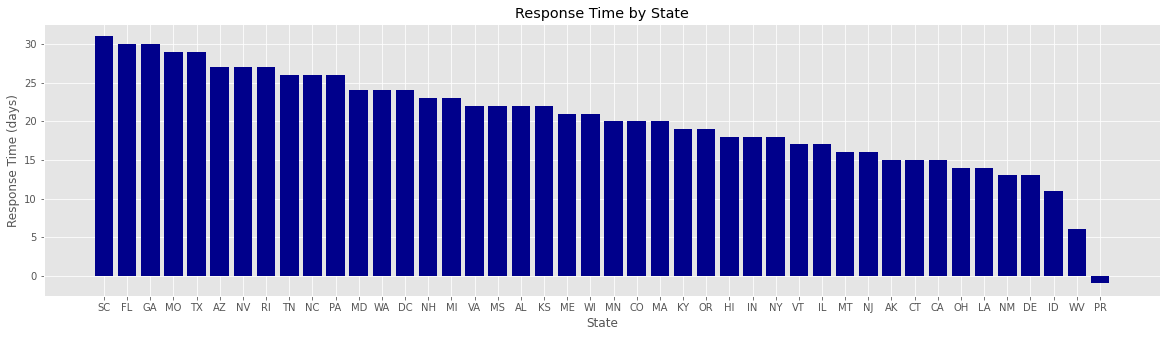

In [21]:
plt.style.use('ggplot')
barplotdata = SAH_data.sort_values('Response_time', ascending = False)
fig, ax = plt.subplots(1, 1, figsize = (20, 5))
ax.bar(barplotdata['state'], barplotdata['Response_time'], color = 'darkblue')
ax.set_title('Response Time by State')
ax.set_xlabel('State')
ax.set_ylabel('Response Time (days)');

### Rate of Change of Death Increase (essentially a 2nd derivative of deaths)

In [22]:
# Calculate rate of change in death increases
data['deathIncrease_ROC'] = data['deathIncrease'].diff(periods = -1)

In [23]:
# Fix last row in each state group
last_row_index = data.groupby('state').tail(1).index
for i in range(len(last_row_index)):
    data.at[last_row_index[i], 'deathIncrease_ROC'] = 0

I chose to analyze each death statistic per million people so the numbers would be more easily readable.

### Statistics by State Population

In [24]:
# Create statistics per million people
data['deaths_per_M'] = data['death'] / (data['Population'] / 1000000) # Deaths
data['death_rt_per_M'] = data['deathIncrease'] / (data['Population'] / 1000000) # Death rate
data['deathIncrease_ROC_per_M'] = data['deathIncrease_ROC'] / (data['Population'] / 1000000) # ROC Death rate
data['positive_rt_per_M'] = data['positiveIncrease'] / (data['Population'] / 1000000) # Positive case rate per M
data['positive_per_M'] = data['positive'] / (data['Population'] / 1000000) # Positive per million
data['hospitalized_per_M'] = data['hospitalized'] / (data['Population'] / 1000000)

data.head()

,date,state,positive,death,hospitalized,deathIncrease,hospitalizedIncrease,positiveIncrease,SAH_Order_Date,Population,deathIncrease_ROC,deaths_per_M,death_rt_per_M,deathIncrease_ROC_per_M,positive_rt_per_M,positive_per_M,hospitalized_per_M
0,2020-04-14,AK,285.0,9.0,32.0,1.0,0.0,8.0,2020-03-28,737000,1.0,12.211669,1.356852,1.356852,10.854817,386.702849,43.419267
1,2020-04-13,AK,277.0,8.0,32.0,0.0,1.0,5.0,2020-03-28,737000,0.0,10.854817,0.000000,0.000000,6.784261,375.848033,43.419267
2,2020-04-12,AK,272.0,8.0,31.0,0.0,0.0,15.0,2020-03-28,737000,-1.0,10.854817,0.000000,-1.356852,20.352782,369.063772,42.062415
3,2020-04-11,AK,257.0,8.0,31.0,1.0,3.0,11.0,2020-03-28,737000,1.0,10.854817,1.356852,1.356852,14.925373,348.710991,42.062415
4,2020-04-10,AK,246.0,7.0,28.0,0.0,1.0,11.0,2020-03-28,737000,0.0,9.497965,0.000000,0.000000,14.925373,333.785617,37.991859


### Add Statistics by State to the SAH_data 

In [36]:
# Get totals for each state
max_deaths_rt = data.groupby('state', as_index = False)['deathIncrease_ROC'].max() # Maximum death rate by state
total_deaths_per_M = data.groupby('state', as_index = False)['deaths_per_M'].max() # Maximum deaths per million
max_death_rt_per_M = data.groupby('state', as_index = False)['death_rt_per_M'].max() # maximum death rate per million
max_deathIncrease_ROC_per_M = data.groupby('state', as_index = False)['deathIncrease_ROC_per_M'].max() # Maximum death rate ROC (2nd der.)
total_positive = data.groupby('state', as_index = False)['positive'].max() # Total positive cases
total_positive_per_M = data.groupby('state', as_index = False)['positive_per_M'].max() # Total positive cases per million
total_hospitalized = data.groupby('state', as_index = False)['hospitalized'].max() # Total positive cases
total_hospitalized_per_M = data.groupby('state', as_index = False)['hospitalized_per_M'].max() # Total positive cases per million
max_positive_rt_per_M = data.groupby('state', as_index = False)['positive_rt_per_M'].max() # maximum positive case rate per million

# Add to SAH dataset
SAH_data['max_deathIncrease_ROC'] = pd.DataFrame(max_deaths_rt['deathIncrease_ROC'])
SAH_data['total_deaths_per_M'] = pd.DataFrame(total_deaths_per_M['deaths_per_M']) 
SAH_data['max_death_rt_per_M'] = pd.DataFrame(max_death_rt_per_M['death_rt_per_M'])
SAH_data['max_deathIncrease_ROC_per_M'] = pd.DataFrame(max_deathIncrease_ROC_per_M['deathIncrease_ROC_per_M'])
SAH_data['total_positive'] = pd.DataFrame(total_positive['positive'])
SAH_data['total_positive_per_M'] = pd.DataFrame(total_positive_per_M['positive_per_M'])
SAH_data['total_hospitalized'] = pd.DataFrame(total_hospitalized['hospitalized'])
SAH_data['total_hospitalized_per_M'] = pd.DataFrame(total_hospitalized_per_M['hospitalized_per_M'])
SAH_data['max_positive_rt_per_M'] = pd.DataFrame(max_positive_rt_per_M['positive_rt_per_M'])

SAH_data.head()

,state,SAH_Order_Date,Population,Response_time,date_of_first_case,max_deathIncrease_ROC,total_deaths_per_M,max_death_rt_per_M,max_deathIncrease_ROC_per_M,total_positive,total_positive_per_M,total_hospitalized,total_hospitalized_per_M,max_positive_rt_per_M
1,AK,2020-03-28,737000,15,2020-03-13,6.0,22.448980,2.653061,1.224490,3876.0,791.020408,493.0,100.612245,81.632653
0,AL,2020-04-04,4900000,22,2020-03-13,2.0,12.211669,2.713704,2.713704,285.0,386.702849,32.0,43.419267,29.850746
2,AZ,2020-03-31,7200000,27,2020-03-04,7.0,18.194444,1.666667,0.972222,3806.0,528.611111,0.0,0.000000,40.555556
3,CA,2020-03-19,39600000,15,2020-03-04,110.0,19.141414,2.777778,2.777778,23338.0,589.343434,0.0,0.000000,58.636364
4,CO,2020-03-26,5700000,20,2020-03-06,43.0,54.035088,10.000000,7.543860,7691.0,1349.298246,1493.0,261.929825,150.000000


## Plot Positive Case Rate by State

I thought it would be helpful to visualize the positive case rate per million by state and to include the stay-at-home order date on the plot as well.

In [26]:
# Plot parameters
mindate_1 = min(data['date'])
maxdate_1 = max(data['date'])
min_roc_1 = min(data['positive_rt_per_M'])
max_roc_1 = max(data['positive_rt_per_M'])

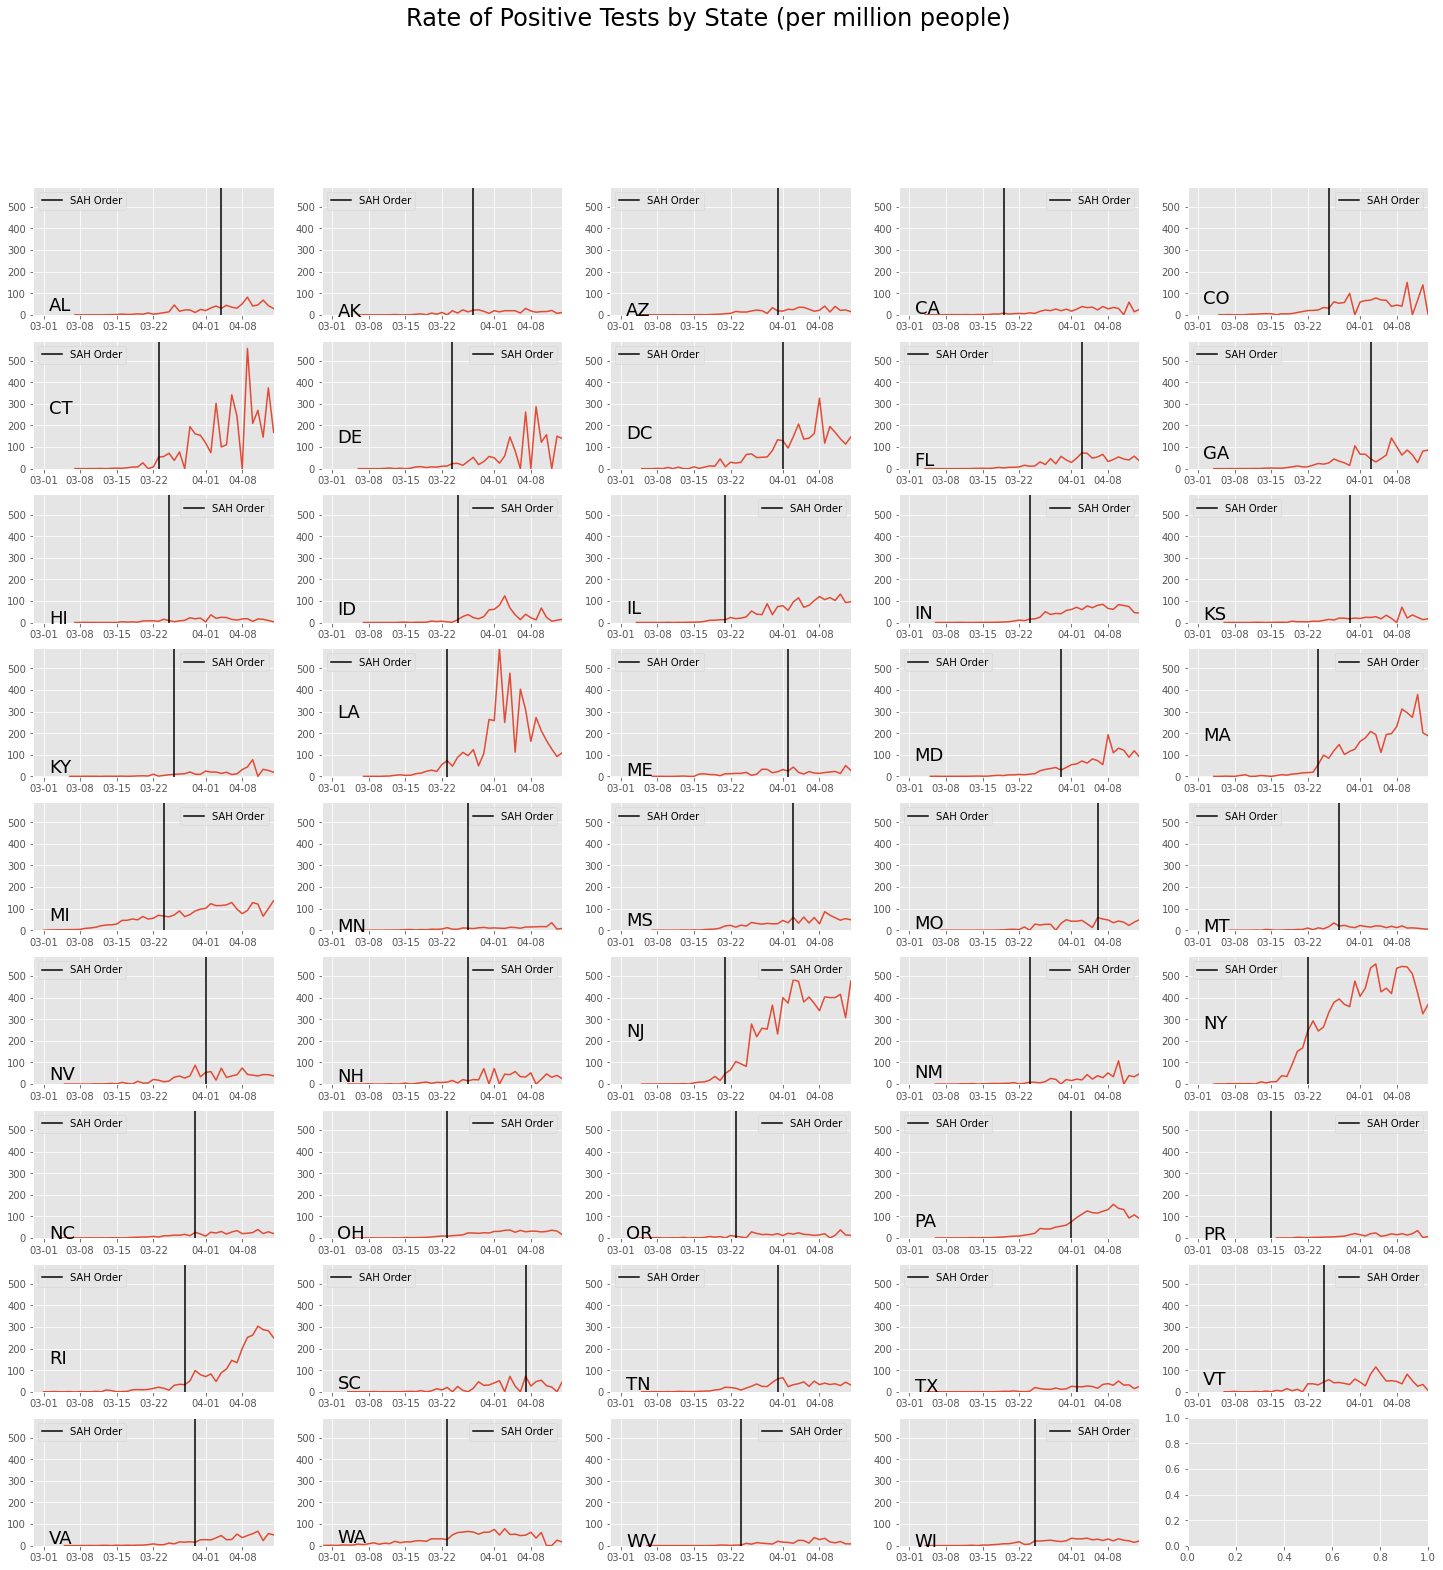

In [27]:
# Plot parameters 2
index = 0
states_used = []
plt.style.use('ggplot')
fig_rows = math.ceil((len(SAH_data) / 5))
myFmt = mdates.DateFormatter('%m-%d')

# Plots
fig, ax = plt.subplots(fig_rows, 5, figsize = (25, 25))
for i in range(fig_rows):
    for j in range(5):
        name = SAH_data['state'][index] # name of the state
        SAHorder = SAH_data['SAH_Order_Date'][index] # Date of the SAH order in that state
        plot_data = data.loc[data['state'] == name] # Data filtered to that state
        centerrate = max(plot_data['positive_rt_per_M']) / 2 # Center of the y-axis for each state
        ax[i, j].plot(plot_data['date'], plot_data['positive_rt_per_M']) # Plot deathIncrease over time
        ax[i, j].set_xlim([mindate_1, maxdate_1]) # set x axis range
        ax[i, j].set_ylim([min_roc_1, max_roc_1])
        ax[i, j].axvline(SAHorder,  label='SAH Order', color='black') # Plot vertical line for SAH order
        ax[i, j].xaxis.set_major_formatter(myFmt) # Format X-axis
        ax[i, j].text(mindate_1 + datetime.timedelta(days=3), centerrate, name, verticalalignment='center', horizontalalignment='left', fontsize = 18) # Put name of state on the chart
        ax[i, j].legend() # label the black line as the Stay at Home Order
        states_used.append(name) # check to make sure all states were used
        if index == (len(SAH_data)-1): # Loop to stop the plotting if the end of the 
            break
        else:
            index = index + 1
fig.suptitle('Rate of Positive Tests by State (per million people)', fontsize=24);

## Plot Death Rate by State

I thought it would be helpful to visualize the death rate per million by state and to include the stay-at-home order date on the plot as well.

In [28]:
# Plot parameters
mindate = min(data['date'])
maxdate = max(data['date'])
min_roc = min(data['death_rt_per_M'])
max_roc = max(data['death_rt_per_M'])

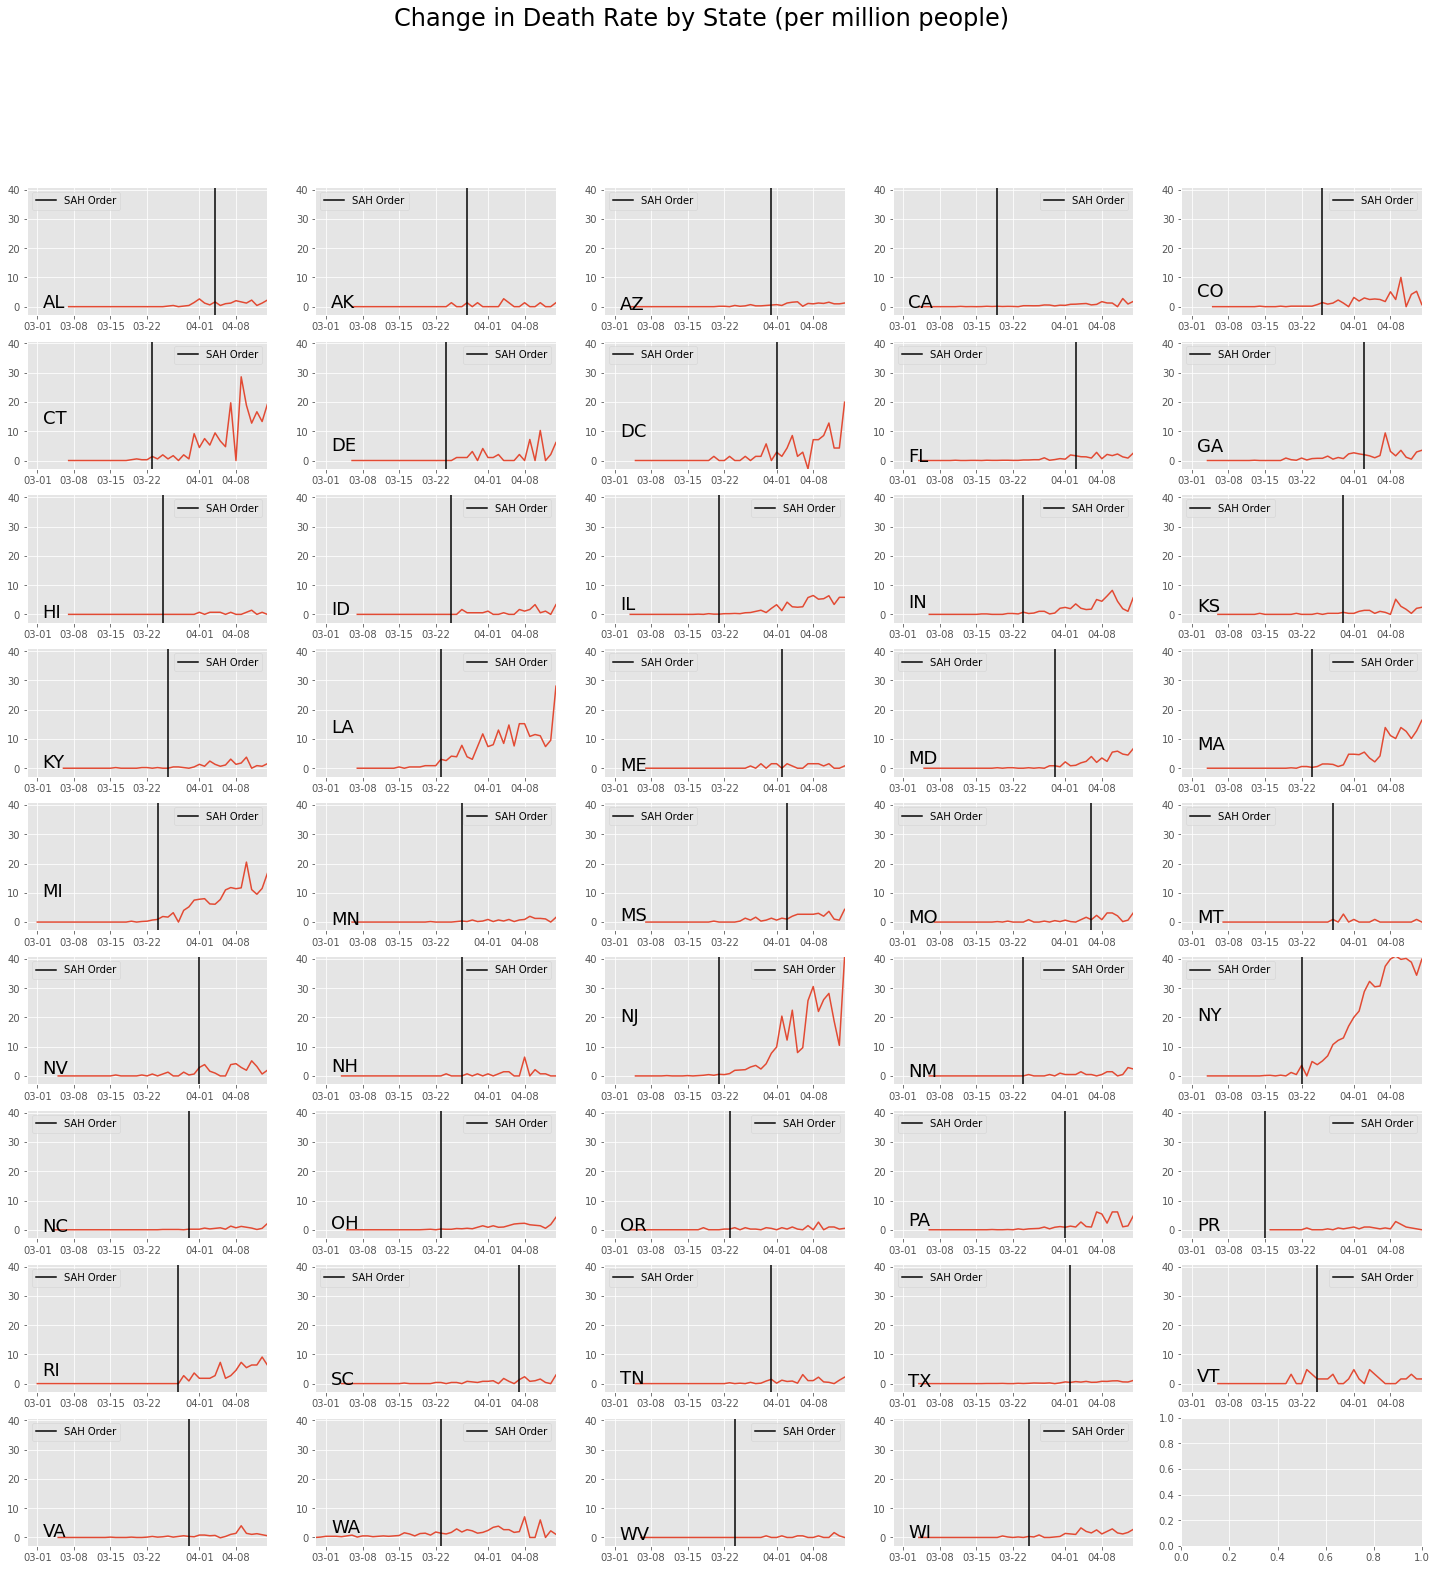

In [29]:
# Plot parameters 2
index = 0
states_used = []
plt.style.use('ggplot')
fig_rows = math.ceil((len(SAH_data) / 5))
myFmt = mdates.DateFormatter('%m-%d')

# Plots
fig, ax = plt.subplots(fig_rows, 5, figsize = (25, 25))
for i in range(fig_rows):
    for j in range(5):
        name = SAH_data['state'][index] # name of the state
        SAHorder = SAH_data['SAH_Order_Date'][index] # Date of the SAH order in that state
        plot_data = data.loc[data['state'] == name] # Data filtered to that state
        centerrate = max(plot_data['death_rt_per_M']) / 2 # Center of the y-axis for each state
        ax[i, j].plot(plot_data['date'], plot_data['death_rt_per_M']) # Plot deathIncrease over time
        ax[i, j].set_xlim([mindate, maxdate]) # set x axis range
        ax[i, j].set_ylim([min_roc, max_roc])
        ax[i, j].axvline(SAHorder,  label='SAH Order', color='black') # Plot vertical line for SAH order
        ax[i, j].xaxis.set_major_formatter(myFmt) # Format X-axis
        ax[i, j].text(mindate + datetime.timedelta(days=3), centerrate, name, verticalalignment='center', horizontalalignment='left', fontsize = 18) # Put name of state on the chart
        ax[i, j].legend() # label the black line as the Stay at Home Order
        states_used.append(name) # check to make sure all states were used
        if index == (len(SAH_data)-1): # Loop to stop the plotting if the end of the 
            break
        else:
            index = index + 1
fig.suptitle('Change in Death Rate by State (per million people)', fontsize=24);

## Modeling

### Positive Cases vs. Response Time

In [31]:
y = SAH_data[['total_positive_per_M']]
X = SAH_data[['Response_time']]
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.20, random_state = 7335786)
model = LinearRegression(fit_intercept = True)
model.fit(Xtrain, ytrain)
model.score(Xtest, ytest)

-0.012782242668338384

In [32]:
y = SAH_data[['max_positive_rt_per_M']]
X = SAH_data[['Response_time']]
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.20, random_state = 7335786)
model = LinearRegression(fit_intercept = True)
model.fit(Xtrain, ytrain)
model.score(Xtest, ytest)

-0.02879507075286547

### Deaths vs. Response Time

In [33]:
y = SAH_data[['total_deaths_per_M']]
X = SAH_data[['Response_time']]
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.20, random_state = 7335786)
model = LinearRegression(fit_intercept = True)
model.fit(Xtrain, ytrain)
model.score(Xtest, ytest)

-0.039230431121743514

In [34]:
y = SAH_data[['max_death_rt_per_M']]
X = SAH_data[['Response_time']]
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.20, random_state = 7335786)
model = LinearRegression(fit_intercept = True)
model.fit(Xtrain, ytrain)
model.score(Xtest, ytest)

-0.06913311216349571

### Pairs plot to emphasize the lack of relationship

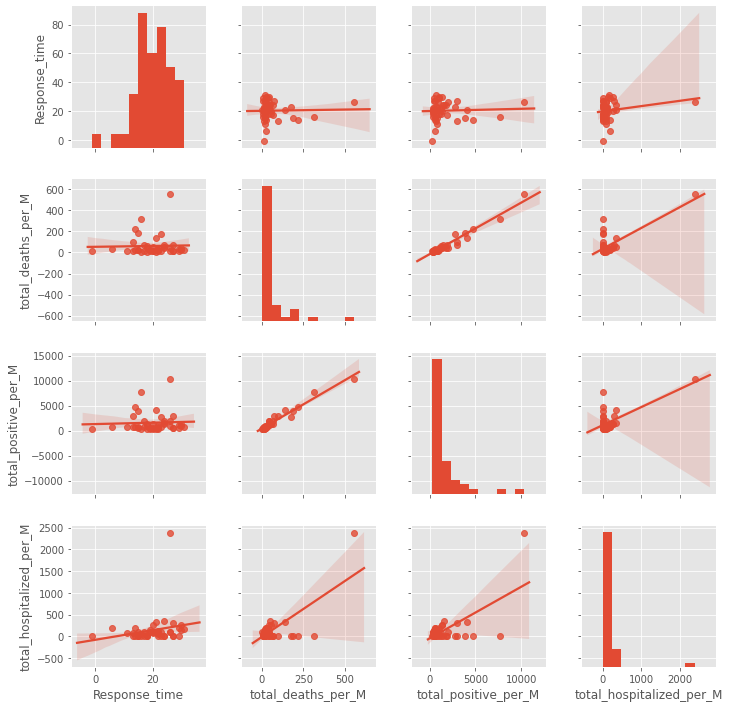

In [35]:
pairs_data = SAH_data[['Response_time', 'total_deaths_per_M', 'total_positive_per_M', 'total_hospitalized_per_M']]
plt.style.use('ggplot')
sns.pairplot(data = pairs_data, kind = 'reg');

## Conclusion

##### After running multiple linear models on this dataset, it appears that  ***there is no relationship between a state's response times and key statistics about the outcomes of COVID-19***.

This conclusion does not mean that the stay-at-home orders are ineffective - it may still be too soon to tell what the effects of the preventative measures were. What it does tell us is that simply ordering people to stay at home is not the silver bullet for this pandemic. This could be due to the way each order was communicated, the people's response to state leadership, and many other social or economic factors, but it is hard to tell at this point. 

## Future Analysis

One thing I did notice in the analysis was the positive relationship between the number of positive cases and the number of deaths. I'm wondering if this says anything about the testing procedures or treatment, or if this just means that people with the most severe symptoms are being tested. It could be worth looking into at some point in the future.  